In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score,mean_absolute_percentage_error
import pickle
import math
import os
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from xgboost.sklearn import XGBRegressor
from tqdm import tqdm

# 读取需求比例

In [ ]:
sample_size = 1000

demand = pd.read_csv("DemandTimeDistribution_Smoothed.csv",encoding='utf-8')

demand['Smoothed_Pro'] = 1/57600

demand['hour'] = demand['T'] // 2400
demand_group = demand.groupby('hour')['Smoothed_Pro'].sum()
demand_group *= sample_size
demand_group = demand_group.astype('int')
demand_group

In [ ]:
num_DiDi_lst = [10,50,100]
date_lst = range(1,30)
pro_Autonavi_lst = list(np.arange(0,0.31,0.05)[1:])
pro_Autonavi_lst = [round(i,3) for i in pro_Autonavi_lst]

total_times = 10

note = '天数无上限&测试集为下一天&1205'

test_note = f'抽取{total_times}次每次{sample_size}条'


In [ ]:
# 设定特征
features = ['Origin','Destination','O Dig','D Dig',  # 起点与终点特征
            'Actual In Time','Hour','Quarter',   # 进入时间特征
            'Acceleration','SlowingPro',  # 车辆特征
            'PathLength','Traffic Light', # 路径特征            
            ] + [f'mean_TravelTime_before_{i}' for i in range(1,7)] + [f'std_TravelTime_before_{i}' for i in range(1,7)] # 时序特征
target = ['Travel Time']

In [ ]:
def getPerformance(y_true , y_pred):
    # 计算回归性能指标
    MSE  = mean_squared_error(y_true,y_pred)
    RMSE = math.sqrt(MSE)
    mae  = mean_absolute_error(y_true,y_pred)
    r2  = r2_score(y_true,y_pred)
    mape = mean_absolute_percentage_error(y_true,y_pred)
    return {'MSE':MSE,'RMSE':RMSE,'MAE':mae,'R2':r2,'MAPE':mape}

In [ ]:
didi_res_lst = []

for n in num_DiDi_lst:

    for date in tqdm(date_lst):

        didi_model_path = f"Model/{note}/TimeFeature_DiDi_n{n}_date{date}_xgb_model.pkl"
        didi_model = pickle.load(open(didi_model_path, 'rb'))

        didi_test_data = pd.read_csv(f"TimeFeature_predictResult/{note}/TimeFeature_DiDi_predictions_n{n}_date{date}.csv").drop(columns=['Predicted Travel Time'])

        for times in range(total_times):
            didi_td_lst = []
            hour_performance_lst = [] 

            # 分小时抽取 并计算该小时的平均mape
            for h in range(24):
                temp_df = didi_test_data[didi_test_data['Hour']==h].sample(demand_group[h],replace=True)
                temp_df['Predicted Travel Time'] = didi_model.predict(temp_df[features])

                didi_td_lst.append(temp_df)

                hour_performance_lst.append(round(mean_absolute_percentage_error(temp_df['Travel Time'],temp_df['Predicted Travel Time']),6))

            # 计算一个总的mape
            didi_td = pd.concat(didi_td_lst,ignore_index=True)
            
            mape = round(mean_absolute_percentage_error(didi_td['Travel Time'],didi_td['Predicted Travel Time']),6)

            didi_res_lst.append([n,date,times,mape]+hour_performance_lst)

didi_res_df = pd.DataFrame(didi_res_lst,columns=['num_DiDi','date','times','mape']+['mape'+str(i) for i in range(24)])
didi_res_df = didi_res_df.groupby(['num_DiDi','date']).mean().drop(columns=['times'])
didi_res_df.to_csv(f"Test_Result/DiDi_test_result_{note}_{test_note}.csv",encoding='utf-8')
didi_res_df

In [ ]:
Autonavi_res_lst = []

for n in num_DiDi_lst:

    for pro in pro_Autonavi_lst:

        for date in tqdm(date_lst):

            model_path = f"Model/{note}/TimeFeature_DiDi_n{n}_Autonavi_pro{pro}_date{date}_xgb_model.pkl"
            model = pickle.load(open(model_path, 'rb'))

            test_data = pd.read_csv(f"TimeFeature_predictResult/{note}/TimeFeature_Autonavi_predictions_n{n}_Pro{pro}_date{date}.csv").drop(columns=['Predicted Travel Time'])

            for times in range(total_times):
                td_lst = []
                hour_performance_lst = [] 

                # 分小时抽取 并计算该小时的平均mape
                for h in range(24):
                    temp_df = test_data[test_data['Hour']==h].sample(demand_group[h],replace=True)
                    temp_df['Predicted Travel Time'] = model.predict(temp_df[features])

                    td_lst.append(temp_df)

                    hour_performance_lst.append(round(mean_absolute_percentage_error(temp_df['Travel Time'],temp_df['Predicted Travel Time']),6))

                # 计算一个总的mape
                td = pd.concat(td_lst,ignore_index=True)
                
                mape = round(mean_absolute_percentage_error(td['Travel Time'],td['Predicted Travel Time']),6)

                Autonavi_res_lst.append([n,pro,date,times,mape]+hour_performance_lst)

Autonavi_res_df = pd.DataFrame(Autonavi_res_lst,columns=['num_DiDi','Autonavi_pro','date','times','mape']+['mape'+str(i) for i in range(24)])
Autonavi_res_df = Autonavi_res_df.groupby(['num_DiDi','Autonavi_pro','date']).mean().drop(columns=['times'])
Autonavi_res_df.to_csv(f"Test_Result/Autonavi_test_result_{note}_{test_note}.csv",encoding='utf-8')
Autonavi_res_df

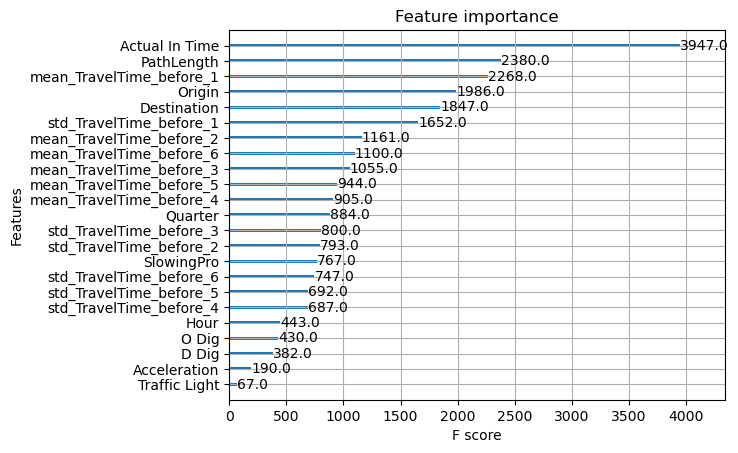

In [5]:
# 查看模型的特征重要性
note = '天数无上限&测试集为下一天&1205'
n = 10
pro = 0.15
date = 5

def drawImportance(xgb_model):
    # 画出XGBoost模型的重要性
    # plt.rcParams['font.sans-serif'] = ['SimHei']
    # print(xgb_model.feature_importances_)
    plot_importance(xgb_model)
    plt.show()

xgb_model_path = f"Model/{note}/TimeFeature_DiDi_n{n}_Autonavi_pro{pro}_date{date}_xgb_model.pkl"
xgb_model = pickle.load(open(xgb_model_path, 'rb'))
drawImportance(xgb_model)
